In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("combined_poetry_dataset.csv")

In [ ]:
!tar -xzf combined_poetry_dataset.tar.gz

<ipython-input-4-8043aa5c7946>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='year_bucket', data=df, palette="viridis")


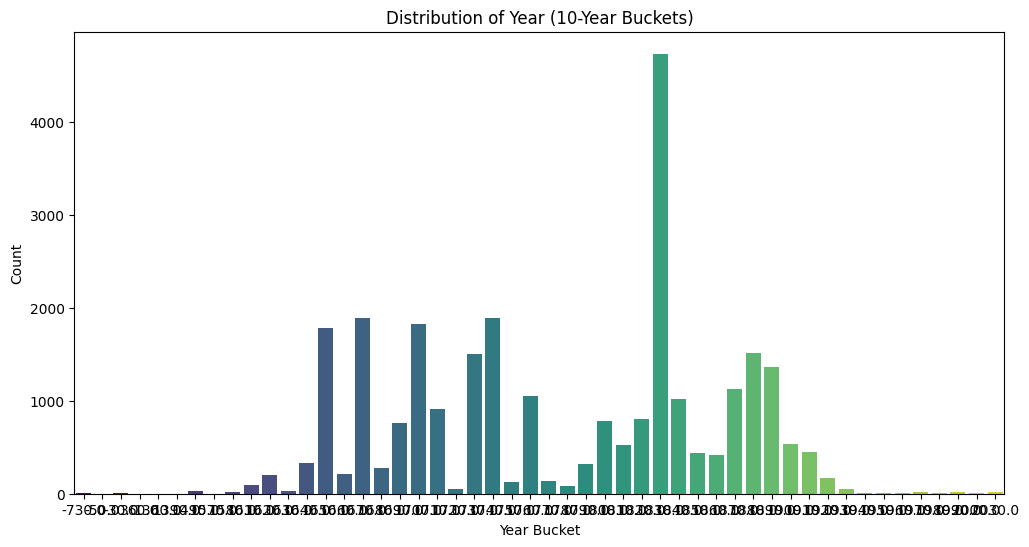

<ipython-input-4-8043aa5c7946>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='theme', data=df, order=df['theme'].value_counts().index, palette="magma")


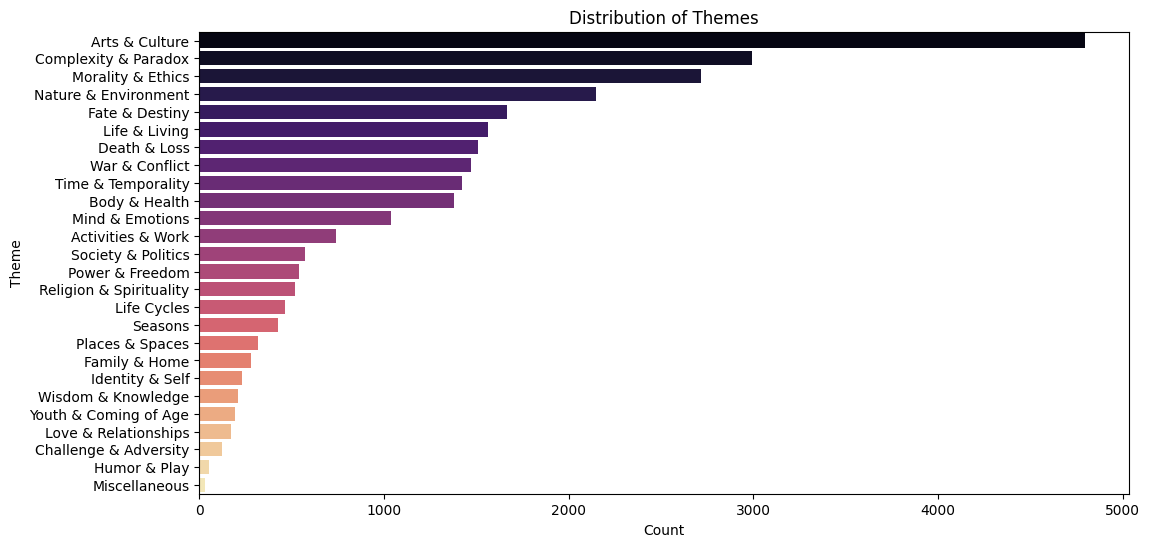

<ipython-input-4-8043aa5c7946>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='language', data=df, order=df['language'].value_counts().index, palette="plasma")


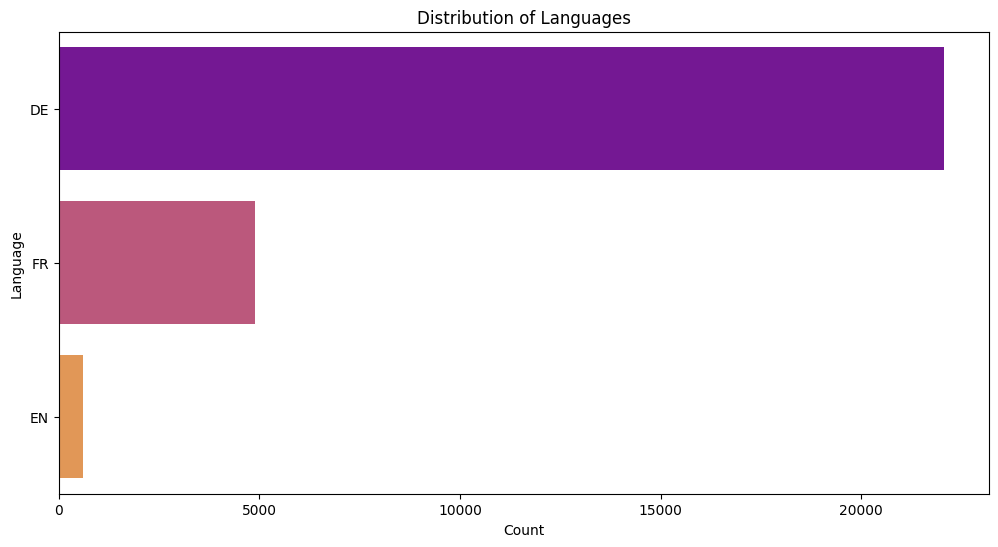

In [ ]:
# prompt: Show the distribution of the "year" column and another distribution for the "theme" column of df, year bucket is 10 years. year column is string. Show counts on columns. Show another distribution for language. Turn "German" into "DE". Make sure to plot

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("combined_poetry_dataset.csv")

# Convert 'year' to numeric, coercing errors to NaN
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Create 10-year buckets for the 'year' column
df['year_bucket'] = (df['year'] // 10) * 10

# Distribution of 'year'
plt.figure(figsize=(12, 6))
sns.countplot(x='year_bucket', data=df, palette="viridis")
plt.title('Distribution of Year (10-Year Buckets)')
plt.xlabel('Year Bucket')
plt.ylabel('Count')
plt.show()

# Distribution of 'theme'
plt.figure(figsize=(12, 6))
sns.countplot(y='theme', data=df, order=df['theme'].value_counts().index, palette="magma")
plt.title('Distribution of Themes')
plt.xlabel('Count')
plt.ylabel('Theme')
plt.show()


# Replace "German" with "DE" in the 'language' column
df['language'] = df['language'].replace('German', 'DE')

# Distribution of 'language'
plt.figure(figsize=(12, 6))
sns.countplot(y='language', data=df, order=df['language'].value_counts().index, palette="plasma")
plt.title('Distribution of Languages')
plt.xlabel('Count')
plt.ylabel('Language')
plt.show()


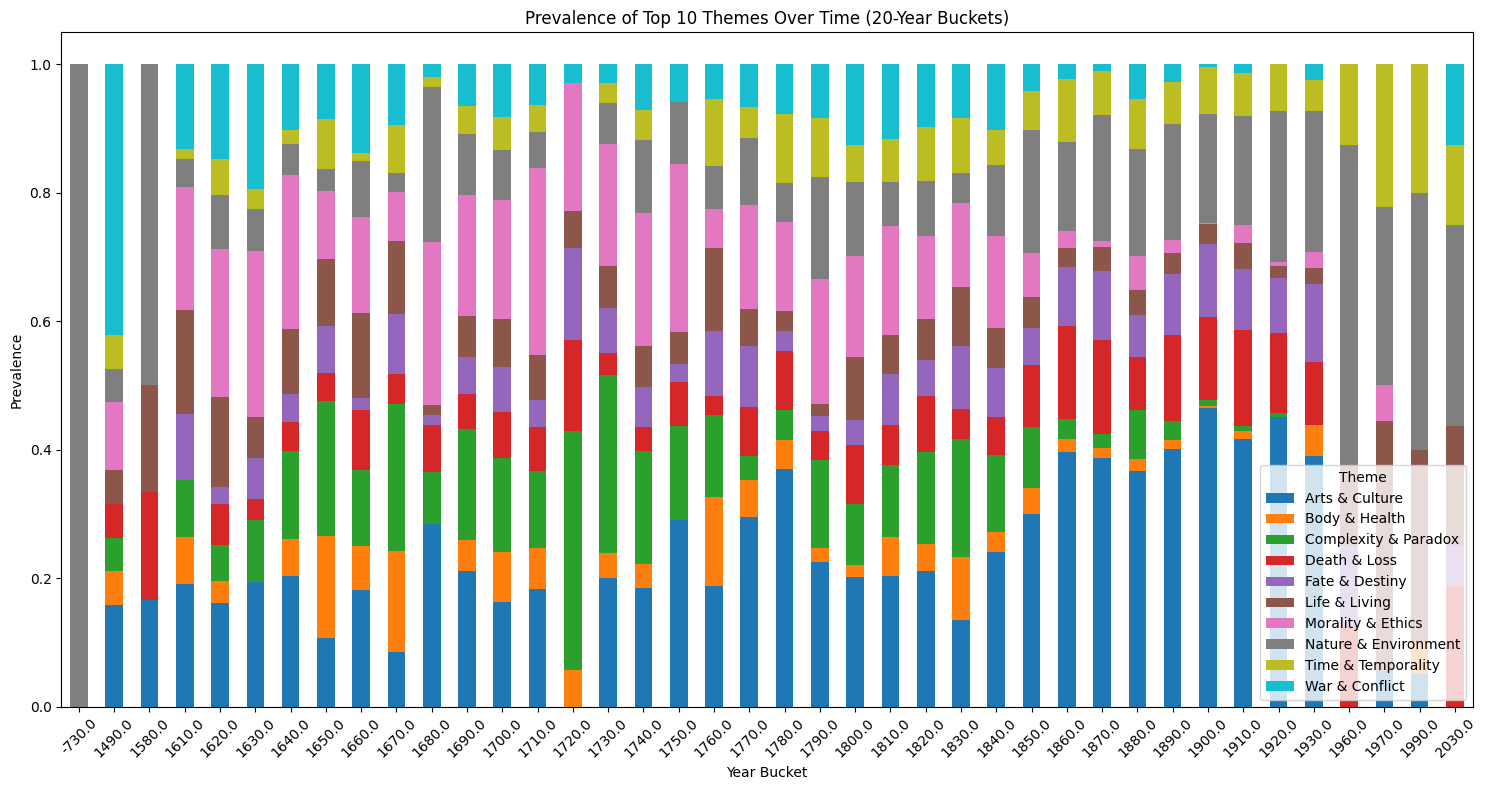

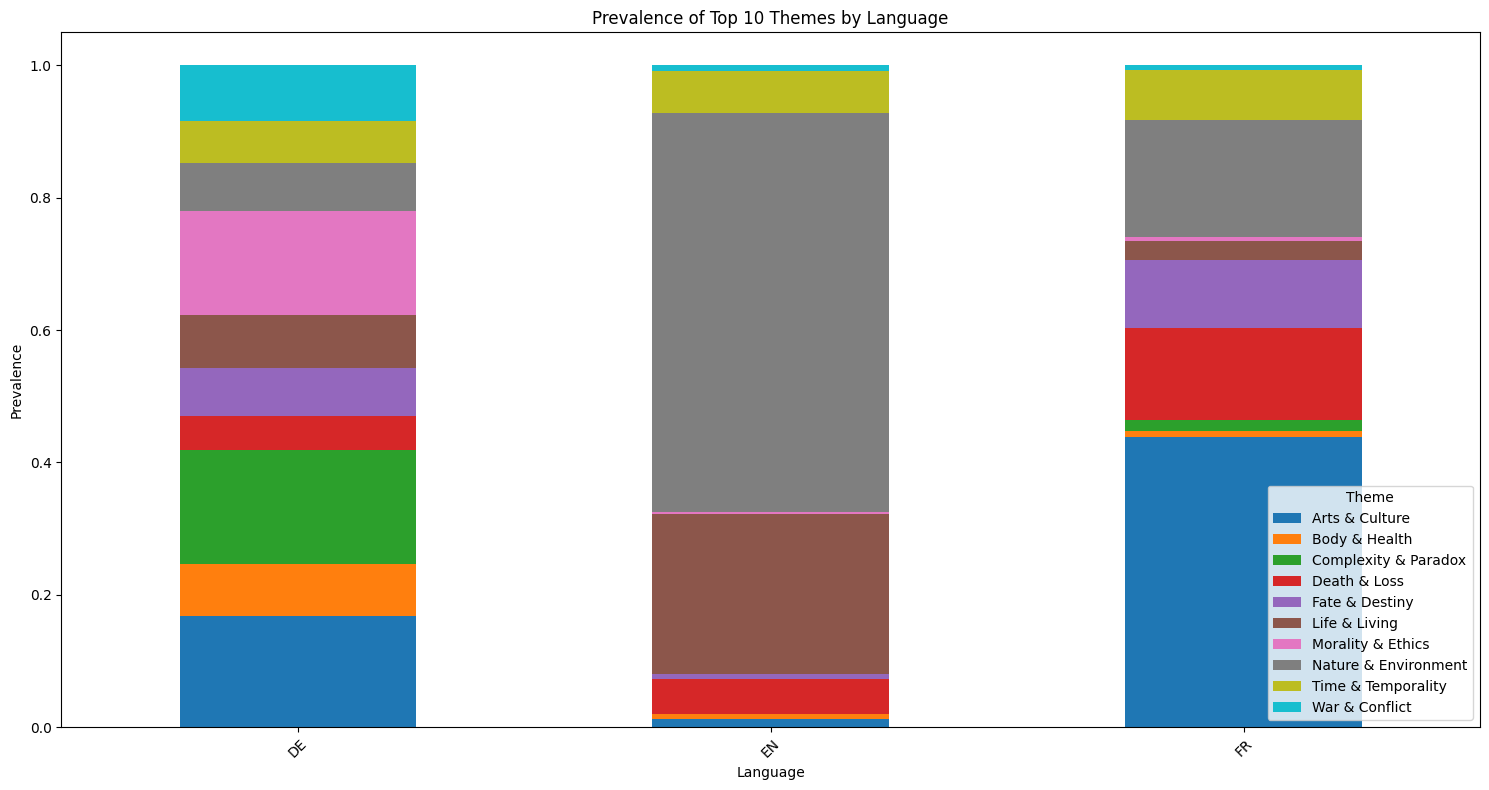

In [ ]:
# prompt: Plot the prevalence of each theme in each 20-year bucket. For now just consider 10 most prominent themes. Should be a groupby "year_bucket", "theme" followed by a div of the sum over axis 1. Don't consider years with fewer than 10 poems. Do the exact same thing but instead of 20-year buckets do language

import matplotlib.pyplot as plt
# Group by year bucket and theme, count occurrences
theme_counts_by_year = df.groupby(['year_bucket', 'theme']).size().reset_index(name='counts')

# Filter out buckets with fewer than 10 poems
year_counts = df.groupby('year_bucket').size()
valid_years = year_counts[year_counts >= 10].index
theme_counts_by_year = theme_counts_by_year[theme_counts_by_year['year_bucket'].isin(valid_years)]

# Get the 10 most prominent themes
top_10_themes = theme_counts_by_year.groupby('theme')['counts'].sum().nlargest(10).index
theme_counts_by_year = theme_counts_by_year[theme_counts_by_year['theme'].isin(top_10_themes)]

# Calculate prevalence
theme_prevalence = theme_counts_by_year.groupby(['year_bucket', 'theme'])['counts'].sum().unstack(fill_value=0)
theme_prevalence = theme_prevalence.div(theme_prevalence.sum(axis=1), axis=0)

# Plot the prevalence
theme_prevalence.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Prevalence of Top 10 Themes Over Time (20-Year Buckets)')
plt.xlabel('Year Bucket')
plt.ylabel('Prevalence')
plt.xticks(rotation=45)
plt.legend(title='Theme')
plt.tight_layout()
plt.show()


# Group by language and theme, then calculate prevalence
theme_counts_by_lang = df.groupby(['language', 'theme']).size().reset_index(name='counts')
lang_counts = df.groupby('language').size()
valid_langs = lang_counts[lang_counts >= 10].index  # Consider languages with at least 10 poems
theme_counts_by_lang = theme_counts_by_lang[theme_counts_by_lang['language'].isin(valid_langs)]

# Get the 10 most prominent themes across all languages
top_10_themes_lang = theme_counts_by_lang.groupby('theme')['counts'].sum().nlargest(10).index
theme_counts_by_lang = theme_counts_by_lang[theme_counts_by_lang['theme'].isin(top_10_themes_lang)]

theme_prevalence_lang = theme_counts_by_lang.groupby(['language', 'theme'])['counts'].sum().unstack(fill_value=0)
theme_prevalence_lang = theme_prevalence_lang.div(theme_prevalence_lang.sum(axis=1), axis=0)

# Plot the prevalence
theme_prevalence_lang.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Prevalence of Top 10 Themes by Language')
plt.xlabel('Language')
plt.ylabel('Prevalence')
plt.xticks(rotation=45)
plt.legend(title='Theme')
plt.tight_layout()
plt.show()


In [ ]:
len(df)

27569

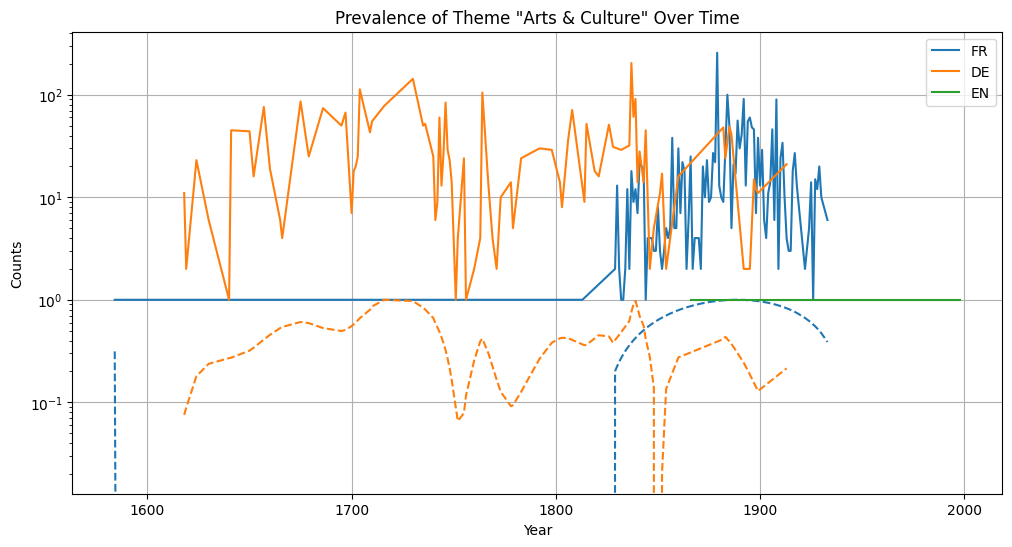

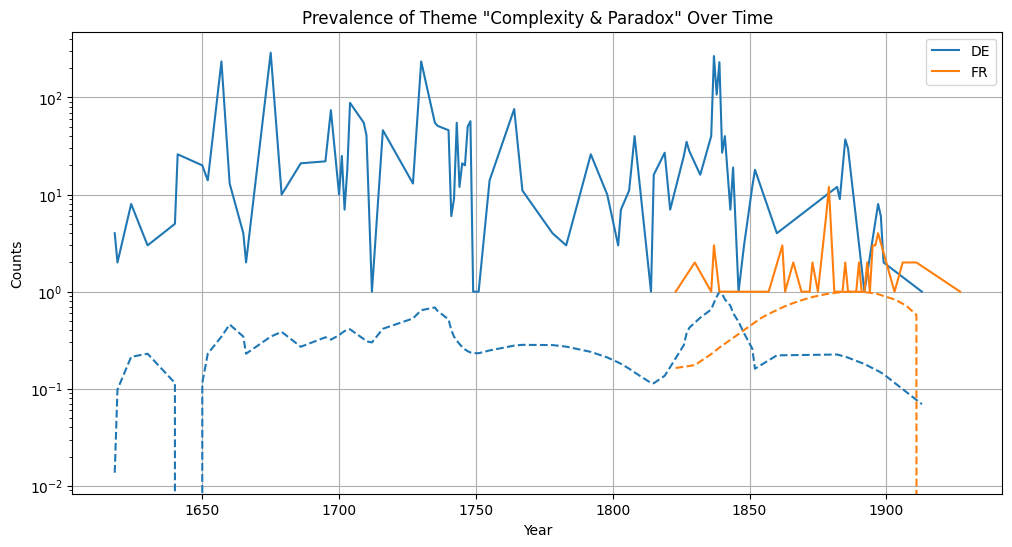

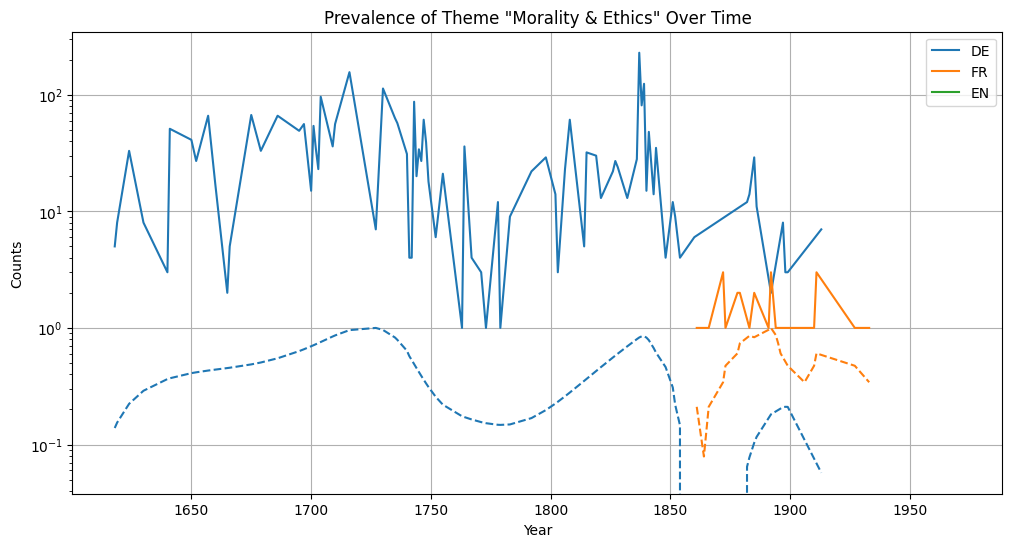

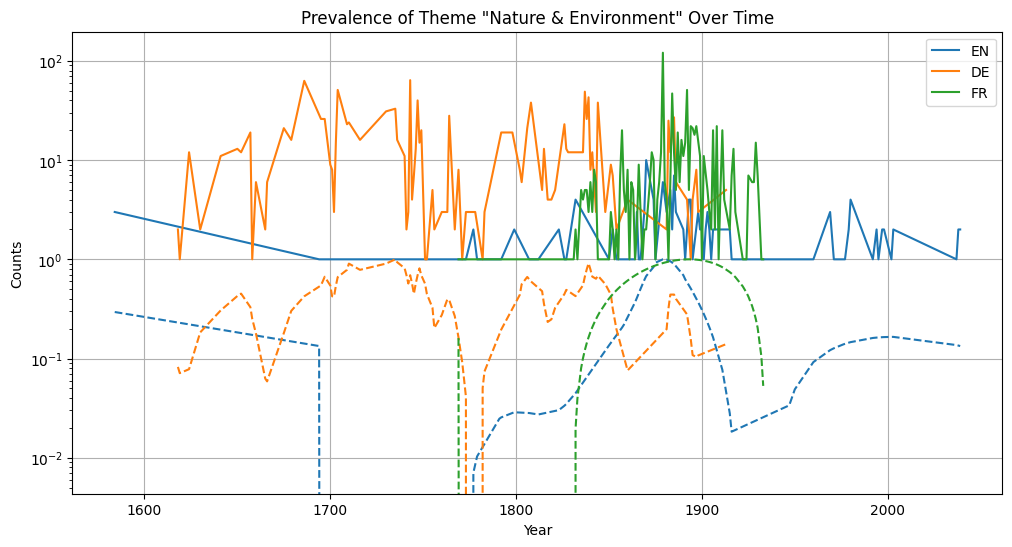

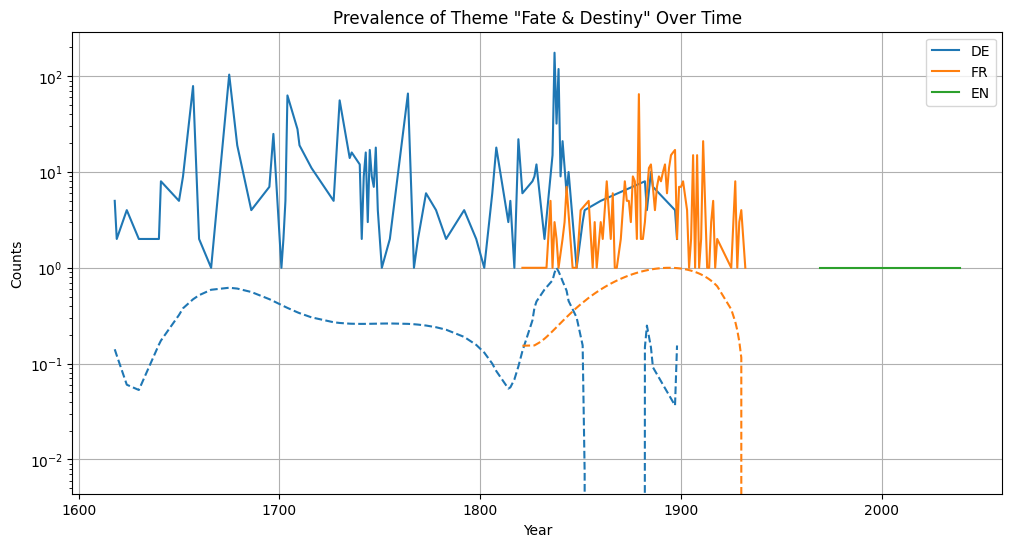

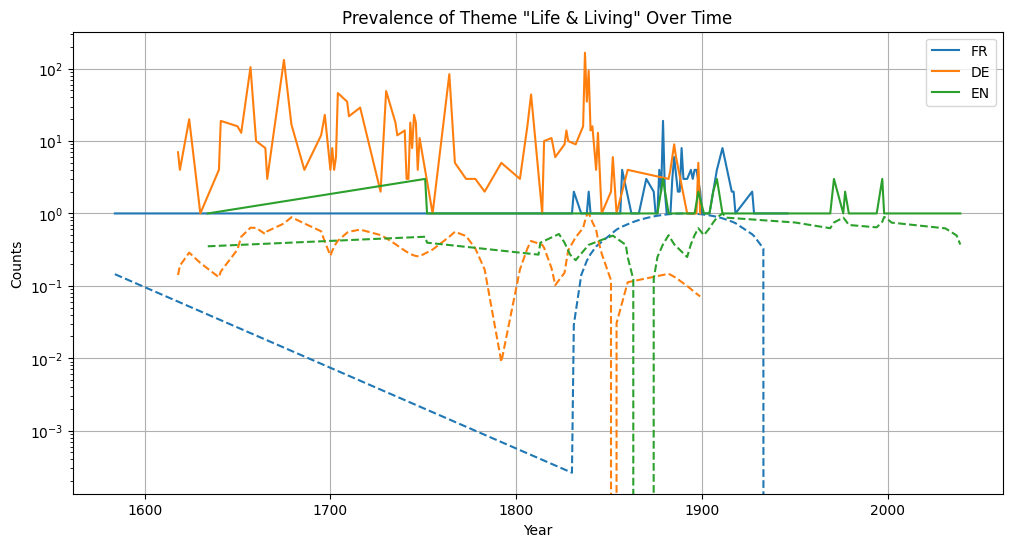

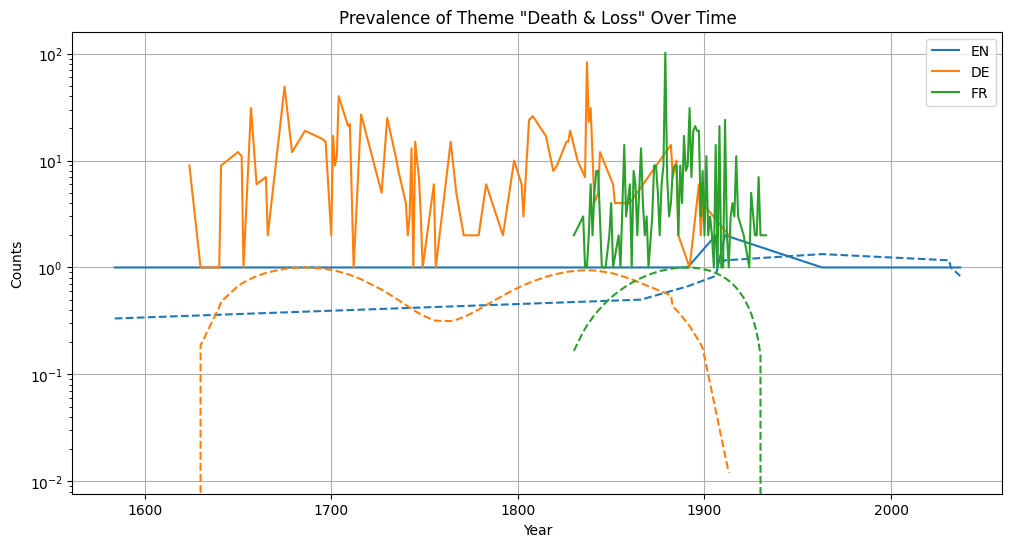

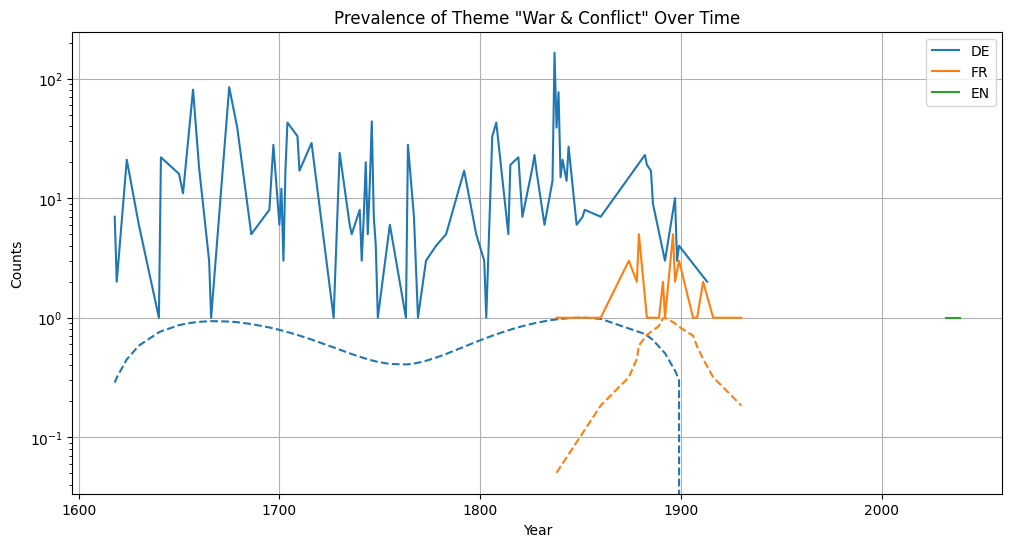

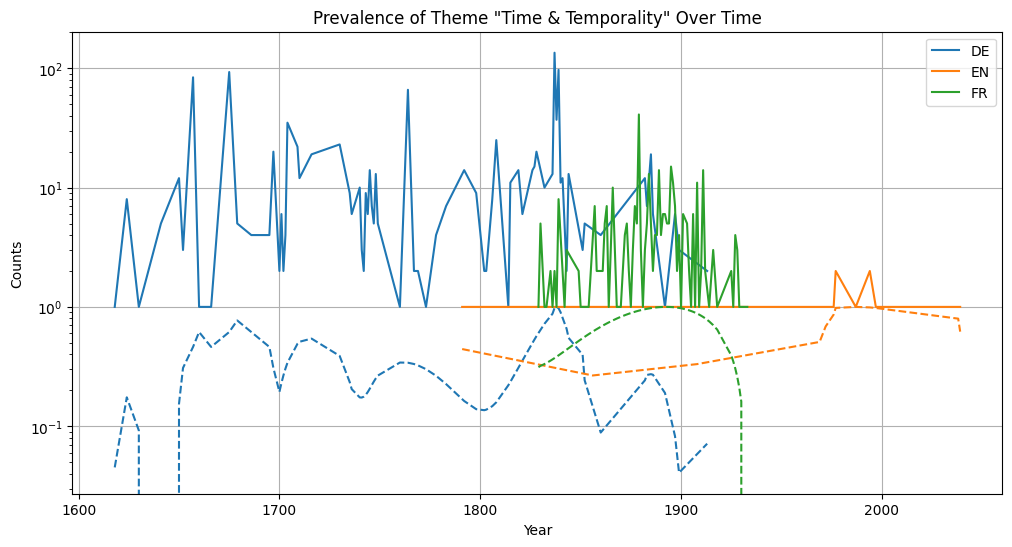

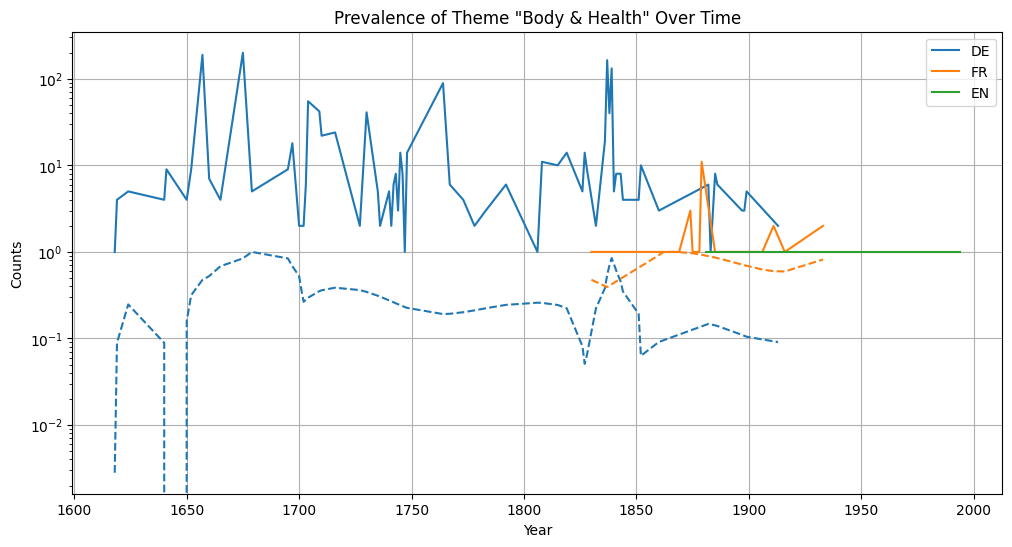

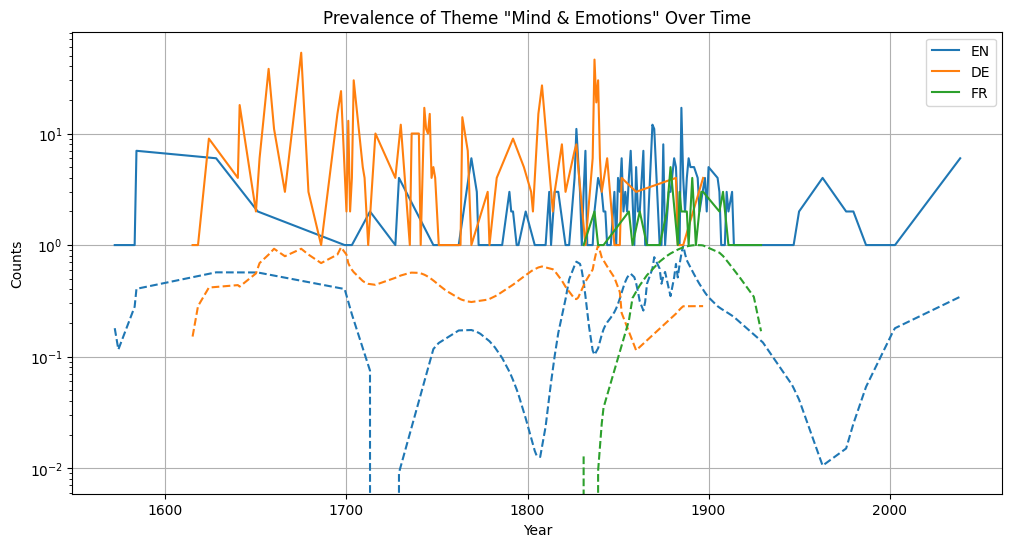

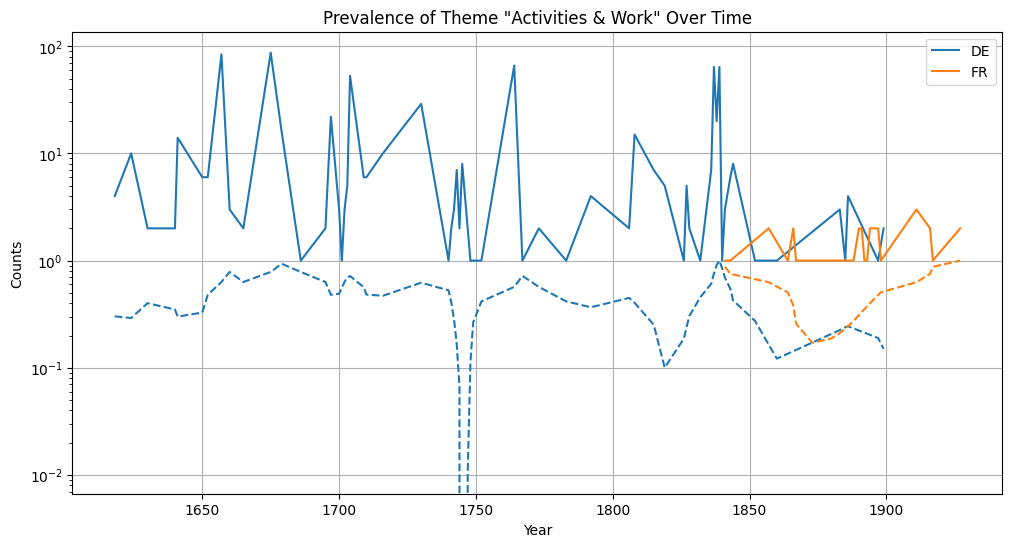

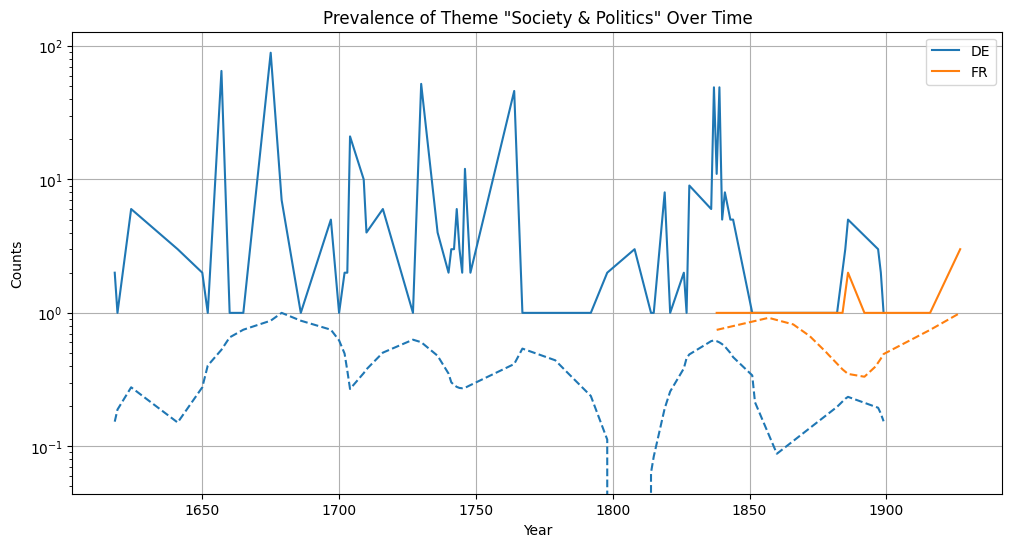

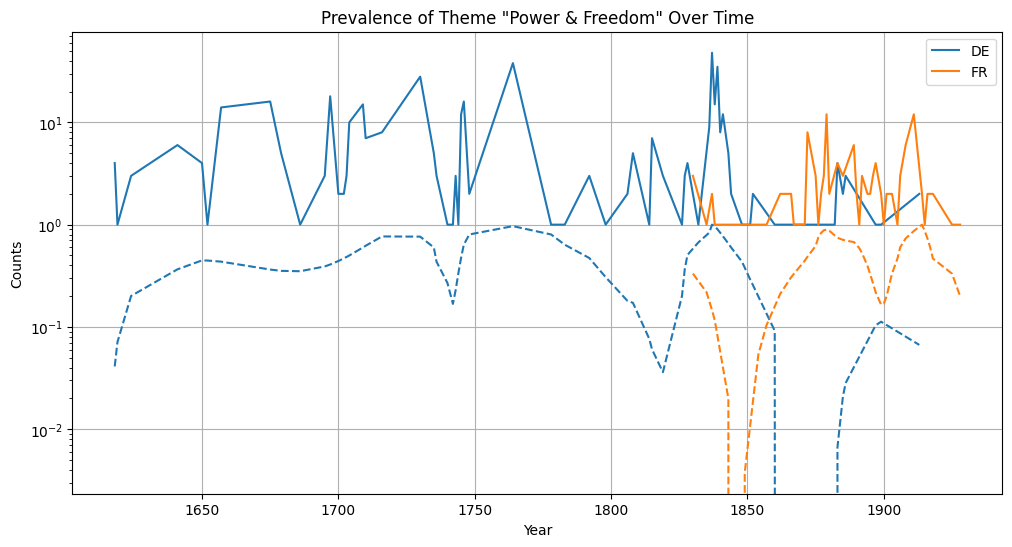

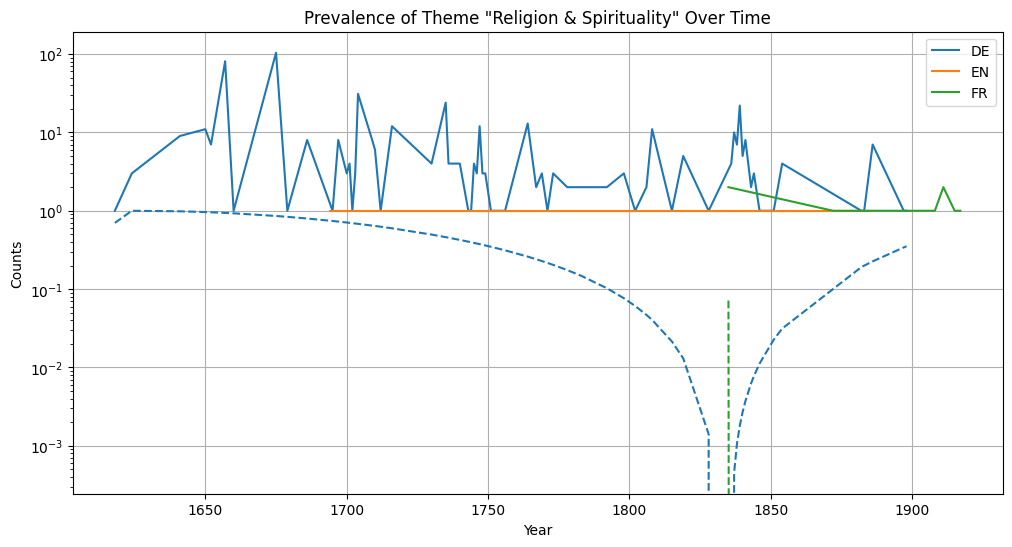

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline

# Filter out years before 1500
df = df[df['year'] >= 1500]

# Group data for plotting
theme_counts = df.groupby(['year', 'theme', 'language']).size().reset_index(name='counts')

# Get top 10 themes
top_15_themes = theme_counts.groupby('theme')['counts'].sum().nlargest(15).index

# Filter for top 10 themes
theme_counts = theme_counts[theme_counts['theme'].isin(top_15_themes)]

funcs = {}

import numpy as np
from scipy.interpolate import UnivariateSpline

def get_normalized_spline_with_step_limit(years, counts, max_step=0.05, s=1):
    """
    Fits a spline to the normalized counts, enforcing a maximum step size between consecutive points.

    Args:
        years: List of years.
        counts: List of counts (data).
        max_step: Maximum allowed step size between consecutive points.
        s: Smoothing factor for UnivariateSpline.

    Returns:
        A function that returns the normalized spline value with step size constraints.
    """
    years = np.array(years)
    counts = np.array(counts, dtype=float)

    # Normalize counts to [0, 1]
    y_min, y_max = counts.min(), counts.max()
    if y_max == y_min:
        norm_counts = np.zeros_like(counts)
    else:
        norm_counts = (counts - y_min) / (y_max - y_min)

    # Fit the spline
    if len(years) < 4:
        # Not enough points for cubic spline — use linear
        return lambda x: 0
    spline = UnivariateSpline(years, norm_counts, s=s)

    # Function to apply step constraint between consecutive points
    def constrained_spline(x):
        spline_value = spline(x)

        # Apply step constraint (enforce max change between consecutive points)
        if hasattr(constrained_spline, 'last_value'):
            prev_value = constrained_spline.last_value
            step = abs(spline_value - prev_value)
            if step > max_step:
                spline_value = prev_value + np.sign(spline_value - prev_value) * max_step

        constrained_spline.last_value = spline_value
        return spline_value

    constrained_values = [constrained_spline(year) for year in years]

    # Re-normalize the constrained values to [0, 1]
    constrained_min = min(constrained_values)
    constrained_max = max(constrained_values)

    # If all values are the same, return 0
    if constrained_max == constrained_min:
        return lambda x: 0.0

    # Normalize the constrained spline values to [0, 1]
    def final_spline(x):
        val = constrained_spline(x)
        return (val - constrained_min) / (constrained_max - constrained_min)

    return final_spline

for theme in top_15_themes:
    funcs[theme] = {}
    plt.figure(figsize=(12, 6))
    theme_data = theme_counts[theme_counts['theme'] == theme]

    for language in theme_data['language'].unique():
        lang_data = theme_data[theme_data['language'] == language].sort_values('year')

        # Plot raw counts
        plt.plot(lang_data['year'], lang_data['counts'], label=language)

        # Fit and plot spline
        years = lang_data['year'].values
        counts = lang_data['counts'].values
        spline_func = get_normalized_spline_with_step_limit(years, counts, s=1.5)
        funcs[theme][language] = (years, spline_func)

        spline_values = [spline_func(y) for y in years]
        plt.plot(years, spline_values, linestyle='--', color=plt.gca().lines[-1].get_color())

    plt.title(f'Prevalence of Theme \"{theme}\" Over Time')
    plt.xlabel('Year')
    plt.ylabel('Counts')
    plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.show()


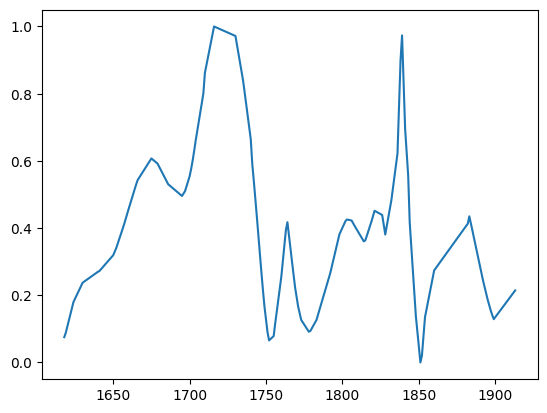

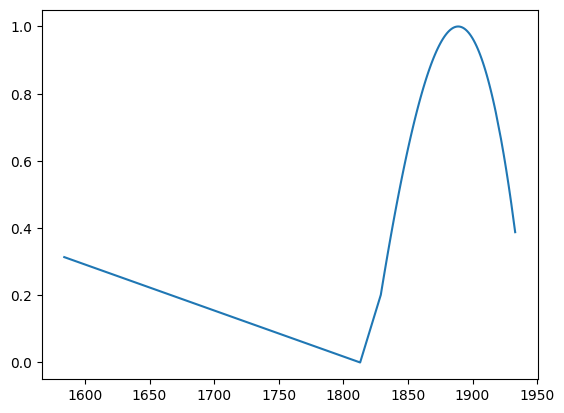

In [ ]:
theme = 'Arts & Culture'
plt.plot(funcs[theme]['DE'][0], [funcs[theme]['DE'][1](i) for i in funcs[theme]['DE'][0]])
plt.show()
plt.plot(funcs[theme]['FR'][0], [funcs[theme]['FR'][1](i) for i in funcs[theme]['FR'][0]])
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
from matplotlib.cm import coolwarm
from matplotlib.colors import LogNorm

def filter_main_landmass(geometry):
    if isinstance(geometry, MultiPolygon):
        return max(geometry.geoms, key=lambda p: p.area)
    return geometry

def plot_heatmap(funcs, theme, year, save_path=None):
    world = gpd.read_file("./ne_110m_admin_0_countries.shp")
    countries = world[world['NAME'].isin(['Germany', 'France'])].copy()

    # Keep only main landmass
    countries['geometry'] = countries['geometry'].apply(filter_main_landmass)

    fig, ax = plt.subplots(figsize=(6, 6))
    countries.plot(ax=ax, color='lightgray', edgecolor='black')
    cmap = coolwarm
    values = [funcs[theme][country][1](year) for country in ['FR', 'DE']]

    for idx, (geometry, value) in enumerate(zip(countries.geometry, values)):
        color = cmap(value)
        if isinstance(geometry, Polygon):
            ax.fill(geometry.exterior.xy[0], geometry.exterior.xy[1], color=color, alpha=0.8)
        elif isinstance(geometry, MultiPolygon):
            for poly in geometry.geoms:
                ax.fill(poly.exterior.xy[0], poly.exterior.xy[1], color=color, alpha=0.8)

        # Add country label
        centroid = geometry.centroid
        ax.text(centroid.x, centroid.y, countries.iloc[idx]['NAME'], ha='center', fontsize=10)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.6, label=f'{theme} prevalence')

    ax.set_title(f"{theme}: {year}")
    ax.set_axis_off()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=100)
    # plt.show()

theme_counts = df.groupby(['year', 'theme', 'language']).size().reset_index(name='counts')
# Get top 10 themes (you can adjust this number)
top_15_themes = theme_counts.groupby('theme')['counts'].sum().nlargest(15).index

import os
import imageio.v2 as imageio
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
from tqdm import tqdm

def generate_gif_for_theme(theme):
    theme_fn = theme.replace(" ", "_").replace("&", "and")
    os.makedirs(f"frames/{theme_fn}", exist_ok=True)

    # Generate and save plots
    frame_paths = []
    for year in tqdm(range(1700, 1900), desc=theme):
        path = f"frames/{theme_fn}/frame_{year}.png"
        frame_paths.append(path)
        plot_heatmap(funcs, theme, year, save_path=path)
        plt.close()  # Free up memory from matplotlib figures

    # Load images and save GIF
    frames = [imageio.imread(p) for p in frame_paths]
    imageio.mimsave(f"{theme_fn}_animation.gif", frames, duration=1, loop=0)
    del frames

# generate_gif_for_theme(top_15_themes[0])

# Run in parallel
with ProcessPoolExecutor() as executor:
    executor.map(generate_gif_for_theme, list(top_15_themes))


Religion & Spirituality: 100%|██████████| 200/200 [01:12<00:00,  2.74it/s]


In [ ]:
df.to_csv("processed_data.csv")

In [ ]:
!tar -czvf output_bundle.tar.gz processed_data.csv frames/

processed_data.csv
frames/
frames/Mind_and_Emotions/
frames/Mind_and_Emotions/frame_1764.png
frames/Mind_and_Emotions/frame_1831.png
frames/Mind_and_Emotions/frame_1706.png
frames/Mind_and_Emotions/frame_1709.png
frames/Mind_and_Emotions/frame_1822.png
frames/Mind_and_Emotions/frame_1889.png
frames/Mind_and_Emotions/frame_1896.png
frames/Mind_and_Emotions/frame_1780.png
frames/Mind_and_Emotions/frame_1793.png
frames/Mind_and_Emotions/frame_1756.png
frames/Mind_and_Emotions/frame_1888.png
frames/Mind_and_Emotions/frame_1748.png
frames/Mind_and_Emotions/frame_1891.png
frames/Mind_and_Emotions/frame_1804.png
frames/Mind_and_Emotions/frame_1703.png
frames/Mind_and_Emotions/frame_1823.png
frames/Mind_and_Emotions/frame_1870.png
frames/Mind_and_Emotions/frame_1827.png
frames/Mind_and_Emotions/frame_1898.png
frames/Mind_and_Emotions/frame_1811.png
frames/Mind_and_Emotions/frame_1708.png
frames/Mind_and_Emotions/frame_1876.png
frames/Mind_and_Emotions/frame_1783.png
frames/Mind_and_Emotions/fr